In [1]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [3]:
import os 
import numpy as np
import itertools
import scipy as sci
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import scanpy as sc
import anndata as ann

from scipy.sparse import csr_matrix, issparse
import matplotlib
from matplotlib import rcParams
from matplotlib import colors

import upsetplot

sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 8.3.2
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
h5py                3.7.0
hypergeom_ufunc     NA
igraph              0.9.11
ipykernel           6.17.1
ipython_genutils    0.2.0
ipywidgets          8.0.6
jedi                0.18.1
joblib              1.2.0
jupyter_server      1.23.2
kiwisolver          1.4.4
leidenalg           0.8.10
llvmlite            0.36.0
matplotlib          3.5.3
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.53.1
numpy               1.20.3
packaging           21.3
pandas              1.5.1
parso  

# Load data

In [4]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')
#adata.obs['region'] = adata.obs['region'].cat.rename_categories({'Skull': 'Calvaria'})
# -> not applied here, conversion for DE plots comes at a later point

bones = np.array(["Calvaria","Vertebra","Humerus","Femur","Pelvis"])#, 'Scapula'])

# Decide group combinations by highest mean difference and do stats tests on top
- for each gene
    - compute mean per bone
    - order bones by means
    - take mean differences between neighboring bones
    - define two groups by the largest mean difference
    - test for significance: we test
        - between the two groups
        - and between the two bones with means closest to the border (this makes the tests fairer explanation below)
        - at the end we take the maximal pval of both tests and the minimal logfoldchange
- result plots:
    - we count genes if pval < 0.05 and LFchange > 1 (you might want to adjust these)
        - upset plots
        - matrix plots per cell types of interest
        
        
Test fairness:
When we compare 3 bones vs 3 bones we probably reach the highest significance compared to e.g. 1 bone vs 5. The bones often have comparable cell counts, we test in two ways: according the combination and the two bones that are closest to the border. Both must be significant. Additionally the two tests setting makes sure we're testing for what we're actually interested in:
- mean difference gap is definitely large enough (test between the two bones close to the border)
- mean difference between the two bone groups is significant (test between the two groups)

In [5]:
def get_mean_diff_based_df(adata,ct_key="level1",conditions=["Naive"],min_cells_per_bone=5,verbosity=2,
                           bones=np.array(['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus'])):
    """
    """
    
    # Basic definitions
    from tqdm.notebook import tqdm
    sc.settings.verbosity = 0
    keys = ["names","scores","pvals","pvals_adj","logfoldchanges"]
    adata_cond = adata[adata.obs["condition"].isin(conditions) & adata.obs["region"].isin(bones)].copy()
    dfs = []    
    
    # Filter out cell types
    tmp = pd.concat([adata_cond[adata_cond.obs["region"] == r].obs[ct_key].value_counts() for r in bones],axis=1)
    filtered_out_cts = tmp[(tmp.isnull() | (tmp < min_cells_per_bone)).any(axis=1)].index.tolist()
    celltypes = [ct for ct in adata_cond.obs[ct_key].unique().tolist() if ct not in filtered_out_cts]
    
    
    ############################
    # Tests for all cell types #
    ############################
    
    for ct in (tqdm(celltypes,desc="cell types") if (verbosity > 0) else celltypes):
        # Prepare adata
        a = adata_cond[adata_cond.obs[ct_key] == ct].copy()
    
        ##################################
        # Prepare df for given cell type #
        ##################################
        
        # Compute means
        tmp_means = []
        for r in bones:
            tmp_means.append(a[a.obs["region"] == r].X.mean(axis=0,dtype=np.float64))
            tmp_means[-1] = np.asarray(tmp_means[-1]).reshape(-1)[:,np.newaxis] if issparse(adata.X) else tmp_means[-1][:,np.newaxis]
        means = np.concatenate(tmp_means,axis=1)
        
        # For each gene get the combination of two bone groups defined by the largest mean expression difference between the ordered bones
        df = pd.DataFrame(index=a.var_names, columns = ["celltype"] + bones.tolist() + ["low","high"])
        combinations = np.zeros((adata.n_vars,len(bones)))
        n_regions_in_low_group = np.argmax(np.diff(np.sort(means,axis=1)),axis=1) + 1
        group_orders = np.argsort(means, axis=1)
        lower_border = [bones[group_orders[i][n_regions_in_low_group[i]-1]] for i in range(len(df))]
        higher_border = [bones[group_orders[i][n_regions_in_low_group[i]]] for i in range(len(df))]
        for i in range(len(n_regions_in_low_group)):
            combinations[i,group_orders[i][n_regions_in_low_group[i]:]] = 1
        # Save results in df
        df[bones] = combinations.astype(int)
        df["celltype"] = ct
        df["low"] = lower_border
        df["high"] = higher_border
        
        # Get bones groups combinations and add corresponding identifiers to each gene in df
        combs = [comb for r in range(1,len(bones)) for comb in itertools.combinations(bones, r)]
        df["combination"] = 0 # just to initialize
        for i,comb in enumerate(combs):
            comb_arr = np.array([1 if col in comb else 0 for col in df[bones].columns])
            filt = np.equal(df[bones].values, comb_arr[np.newaxis,:]).all(axis=1)
            df.loc[filt,"combination"] = i
            
        # Get combinations of the two bones at the highest mean difference border and add corresponding identifiers to each gene in df
        # (note, we call them permutations since e.g. Skull-Pelvis and Pelvis-Skull are both possible)
        perms = [perm for perm in itertools.permutations(bones, 2)]
        df["permutation"] = 0
        for i,perm in enumerate(perms):
            filt = (df["low"] == perm[0]) & (df["high"] == perm[1])
            df.loc[filt,"permutation"] = i
            
            
        #############
        # Run Tests #
        #############
        df_results = pd.DataFrame(index=df.index, columns = [f"{key}_{k}" for k in range(2) for key in keys if key != "names"])
        
        # Combinations of two groups of bones
        #for i,comb in enumerate(tqdm(combs,desc="test1: bone groups combinations")):
        for i,comb in enumerate((tqdm(combs,desc="test1: bone groups combinations") if (verbosity > 1) else combs)):
            
            genes = df.loc[df["combination"] == i].index.values
            if len(genes) > 0:
                group = list(comb)
                
                a.obs["tmp"] = "not_in_group"
                a.obs.loc[a.obs["region"].isin(group),"tmp"] = "in_group" 
                a.obs["tmp"] = a.obs["tmp"].astype('category')
                
                try:
                    rank_genes_results = sc.tl.rank_genes_groups(a[:,genes], 
                                            groupby="tmp", 
                                            groups=["in_group"], 
                                            reference="rest",
                                            n_genes=None, 
                                            rankby_abs=False, 
                                            pts=False, 
                                            key_added=None, 
                                            copy=True, 
                                            method='t-test_overestim_var', 
                                            corr_method='benjamini-hochberg', 
                                            ).uns["rank_genes_groups"]    
                    tmp_df = pd.concat([pd.DataFrame(rank_genes_results[key]).rename({"in_group": f"{key}_0"}, axis=1) for key in keys],axis=1)
                    tmp_df = tmp_df.rename({"names_0": "gene"}, axis=1)  
                    tmp_df = tmp_df.set_index("gene")
                    df_results.loc[tmp_df.index,tmp_df.columns] = tmp_df[tmp_df.columns]
                except Exception:
                    print(f"Group {group} vs rest: Couldn't compute test for cell type {ct}. (this should actually not happen!)")  
        
        # Combination of low and high bones (since order plays a role we call them permutations)        
        #for i,perm in enumerate(tqdm(perms,desc="test2: low high combinations")):
        for i,perm in enumerate((tqdm(perms,desc="test2: low high combinations") if (verbosity > 1) else perms)):            
        
            genes = df.loc[df["permutation"] == i].index.values
            if len(genes) > 0:            
                high = [perm[1]]
                reference = list(perm)
                
                try:
                    rank_genes_results = sc.tl.rank_genes_groups(a[a.obs["region"].isin(reference),genes], 
                                            groupby="region", 
                                            groups=high, 
                                            reference="rest",
                                            n_genes=None, 
                                            rankby_abs=False, 
                                            pts=False, 
                                            key_added=None, 
                                            copy=True, 
                                            method='t-test_overestim_var', 
                                            corr_method='benjamini-hochberg', 
                                            ).uns["rank_genes_groups"]    
                    tmp_df = pd.concat([pd.DataFrame(rank_genes_results[key]).rename({high[0]: f"{key}_1"}, axis=1) for key in keys],axis=1)
                    tmp_df = tmp_df.rename({"names_1": "gene"}, axis=1)  
                    tmp_df = tmp_df.set_index("gene")
                    df_results.loc[tmp_df.index,tmp_df.columns] = tmp_df[tmp_df.columns]
                except Exception:
                    print(f"Low {perm[0]} vs high {perm[1]}: Couldn't compute test for cell type {ct}. (this should actually not happen!)")
            
        # Get minimums/maximum of the two tests
        for key in ["pvals","pvals_adj"]:
            df[key] = df_results[[f"{key}_{i}" for i in range(2)]].max(axis=1)
        for key in ["scores","logfoldchanges"]: # we're only interested in positive values, so it doesn't matter that we also take the min for negative values
            df[key] = df_results[[f"{key}_{i}" for i in range(2)]].min(axis=1)  
            
        dfs.append(df)
    return pd.concat(dfs,axis=0)

## Save results dataframes (ONLY NEEDED ONCE)

In [6]:
from tqdm.notebook import tqdm
for ct_key in tqdm(["level1","level2"],desc="cell type key"):
    for conds in tqdm([["Naive"],["Sham"],["MCAO"]],desc="condition"):
        #tmp_dir = RESULTS_DIR+f"DE_tests_mean_diff/{ct_key}/bones_no_scapula/"
        tmp_dir = RESULTS_DIR+f"DE_tests_mean_diff_{DATA_VERSION}/{ct_key}/bones_no_scapula/"
        Path(tmp_dir).mkdir(parents=True, exist_ok=True)
        get_mean_diff_based_df(adata,ct_key=ct_key,conditions=conds,verbosity=1).to_csv(tmp_dir+f"{conds[0]}.csv")

cell type key:   0%|          | 0/2 [00:00<?, ?it/s]

condition:   0%|          | 0/3 [00:00<?, ?it/s]

cell types:   0%|          | 0/12 [00:00<?, ?it/s]

cell types:   0%|          | 0/12 [00:00<?, ?it/s]

cell types:   0%|          | 0/12 [00:00<?, ?it/s]

condition:   0%|          | 0/3 [00:00<?, ?it/s]

cell types:   0%|          | 0/27 [00:00<?, ?it/s]

cell types:   0%|          | 0/23 [00:00<?, ?it/s]

cell types:   0%|          | 0/28 [00:00<?, ?it/s]

## Plots

In [4]:
def matrix_plot(adata,
                combination=["Skull","Vertebra"],
                pval_max=0.05,
                LFchange_min=1,
                condition="Naive",
                ct_key="level1",
                celltypes="all",
                genes_per_ct=None,
                ct_order=None,
                sort_by="pvals_adj",
                sort_by_ascending=True,
                standard_scale="var"):
    """
    """
    bones = np.array(['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus'])#, 'Scapula'])
    #df = pd.read_csv(RESULTS_DIR+f"DE_tests_mean_diff/{ct_key}/bones_no_scapula/{condition}.csv",index_col=0)
    df = pd.read_csv(RESULTS_DIR+f"DE_tests_mean_diff_{DATA_VERSION}/{ct_key}/bones_no_scapula/{condition}.csv",index_col=0)
    
    df = df.loc[(df["pvals_adj"] < pval_max) & (df["logfoldchanges"] > LFchange_min)]
    combination_filt = True
    for r in combination:
        combination_filt = combination_filt & (df[r] == 1)
    for r in [b for b in bones if b not in combination]:
        combination_filt = combination_filt & (df[r] == 0)
        
    df = df[combination_filt]
        
    if sort_by:
        df = df.sort_values(sort_by,ascending=sort_by_ascending)
    
    if celltypes == "all":
        celltypes = df["celltype"].unique().tolist()
        
    for ct in celltypes:
        df_tmp = df[df["celltype"] == ct]
        genes = df_tmp.index.values if (genes_per_ct is None) else df_tmp[:min(len(df_tmp),genes_per_ct)].index.values
        sc.pl.matrixplot(adata[(adata.obs["condition"] == condition) & 
                               adata.obs["region"].isin(bones) & 
                               (adata.obs[ct_key] == ct)], 
                         genes, 
                         "region", 
                         standard_scale=standard_scale,
                         title=ct
                        )
    

def upset_dfs(adata,ct_key="level1",condition = "Naive",pval_max=0.05,LFchange_min=1,n_cts=8):
    """
    
    n_cts: int
        Keep `n_cts` cell types with the highest numbers of DE genes and put the other cell types in group "other".
    """
    bones = np.array(['Skull', 'Pelvis', 'Femur', 'Vertebra', 'Humerus'])#, 'Scapula'])    
    #df = pd.read_csv(RESULTS_DIR+f"DE_tests_mean_diff/{ct_key}/bones_no_scapula/{condition}.csv",index_col=0)
    df = pd.read_csv(RESULTS_DIR+f"DE_tests_mean_diff_{DATA_VERSION}/{ct_key}/bones_no_scapula/{condition}.csv",index_col=0)
    
    df = df.loc[(df["pvals_adj"] < pval_max) & (df["logfoldchanges"] > LFchange_min)]
    cts_to_show = df["celltype"].value_counts().nlargest(n_cts).index.values
    df.loc[~df["celltype"].isin(cts_to_show),"celltype"] = "other"
    
    color_df = pd.DataFrame(data={"celltype":[ct for ct in adata.obs[ct_key].cat.categories if ct in df["celltype"].unique()] + ["other"],
                       "color"   :[adata.uns[f"{ct_key}_colors"][i] for i,ct in enumerate(adata.obs[ct_key].cat.categories ) if ct in df["celltype"].unique()] + ["#808080"]
                      }
                )
    if 'Skull' in df.columns:
        df = df.rename(columns={'Skull': 'Calvaria'})
    return df, color_df
    
        
    

### Naive (level1)

## Plots

Run the following combinations:
- `ct_key="level1"`, `LFchange_min=1`, `n_cts=8`
- `ct_key="level1"`, `LFchange_min=2`, `n_cts=8`
- `ct_key="level2"`, `LFchange_min=1`, `n_cts=16`
- `ct_key="level2"`, `LFchange_min=2`, `n_cts=16`


In [ ]:
# Plan:
# 1. add pseudo counts
# 2. create pooled df and order by all three conditions summed up
# 3. collect df_colors over for loop and create a legend (I think just a custom legend is best, to have it in one line)
# 4. create each upset with correct ordering and pseudo count coloring
# 5. add baseline upset plot
# 6. styling
# 7. create plot for different thresholds

# y label: "# DE genes upregluated in specific group of bones"


In [6]:
n_combs = 15 # Maximum number of shown combinations
ct_key = "level2"
LFc_min = 2
n_cts = 16

# Get dfs for conditions
dfs = {}
dfs_color = {}
for cond in ["Naive", "Sham", "MCAO"]:
    dfs[cond], dfs_color[cond] = upset_dfs(adata,ct_key=ct_key,condition = cond,pval_max=0.05,LFchange_min=LFc_min,n_cts=n_cts)
    dfs[cond] = dfs[cond][bones.tolist() + ["celltype"]]
    
    
# df for lower upset part (and ordering)
df = pd.concat([dfs["Naive"], dfs["Sham"], dfs["MCAO"]])
df = df.reset_index()
df = df[bones.tolist()+['index', 'celltype']].drop_duplicates(keep='last')
df = df.set_index(bones.tolist())

df["value_counts"] = 0
for comb, vcount in df.index.value_counts().items():
    df.loc[comb, "value_counts"] = vcount


# Initialize dataframe that contains the info for each condition which pseudo rows are needed
combs = [comb for comb in df.index.value_counts().index]
df_pseudo = pd.DataFrame(
    columns= bones,
    data = combs
)
df_pseudo = df_pseudo.set_index(bones.tolist())
df_pseudo["order"] = 10000
for i, (comb, vcount) in enumerate(df.index.value_counts().items()):
    df_pseudo.loc[comb, "order"] = i
df_pseudo = df_pseudo.sort_values("order")

# Go through combinations and check if they're available
for cond in dfs.keys():
    df_pseudo[f"{cond}_pseudo"] = False
    for comb in df_pseudo.index:
        if comb not in dfs[cond].set_index(bones.tolist()).index:
            df_pseudo.loc[comb,f"{cond}_pseudo"] = True
            
# Add pseudo row to each condition's dataframe
dfs_pseudo = dfs.copy()
for cond in dfs_pseudo.keys():
    
    tmp = df_pseudo.loc[df_pseudo[f"{cond}_pseudo"]].reset_index()[bones]
    tmp["index"] = 'pseudo' # not that index refers to gene
    tmp["celltype"] = 'other'
    tmp = tmp[bones.tolist()+["index","celltype"]]
    tmp = tmp.set_index(["index"])
    
    dfs_pseudo[cond] = pd.concat([dfs_pseudo[cond], tmp])
    dfs_pseudo[cond] = dfs_pseudo[cond].set_index(bones.tolist())
    
    dfs_pseudo[cond]["order"] = 10000
    for comb in df_pseudo.index:
        dfs_pseudo[cond].loc[comb,"order"] = df_pseudo.loc[comb,"order"]
    dfs_pseudo[cond] = dfs_pseudo[cond].sort_values("order")
    
# Order df
df["order"] = 10000
for comb in df_pseudo.index:
    df.loc[comb,"order"] = df_pseudo.loc[comb,"order"]
df = df.sort_values("order")
    
# Reduce to n_combs combinations
combs_to_show = df_pseudo.loc[df_pseudo["order"] < n_combs].index
for cond in dfs_pseudo.keys():
    dfs_pseudo[cond] = dfs_pseudo[cond].loc[dfs_pseudo[cond].index.isin(combs_to_show)]
df = df.loc[df.index.isin(combs_to_show)]

/opt/python/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
/opt/python/lib/python3.8/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/opt/python/lib/python3.8/site-packages/ipykernel/zmqshell.py:539: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


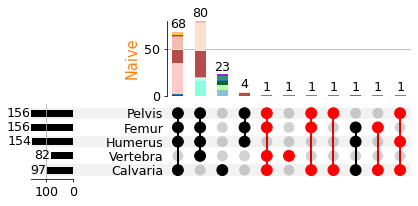

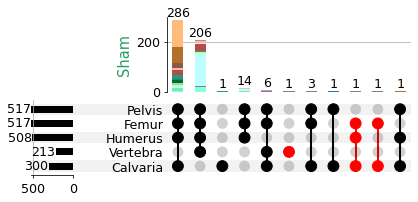

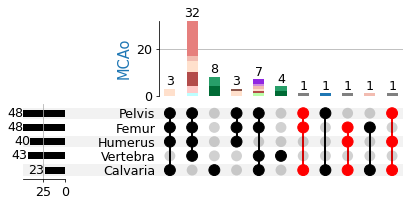

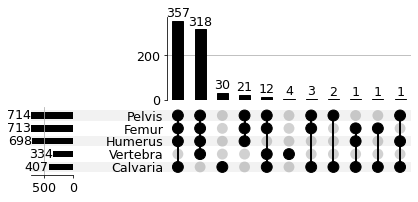

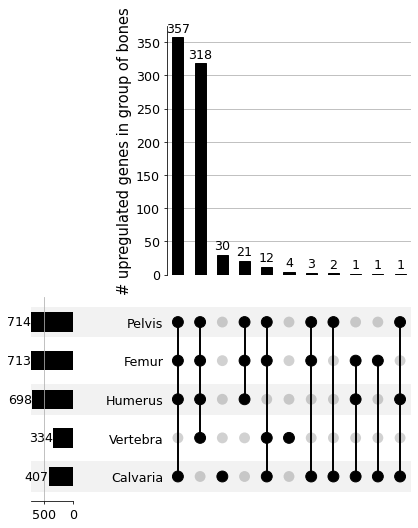

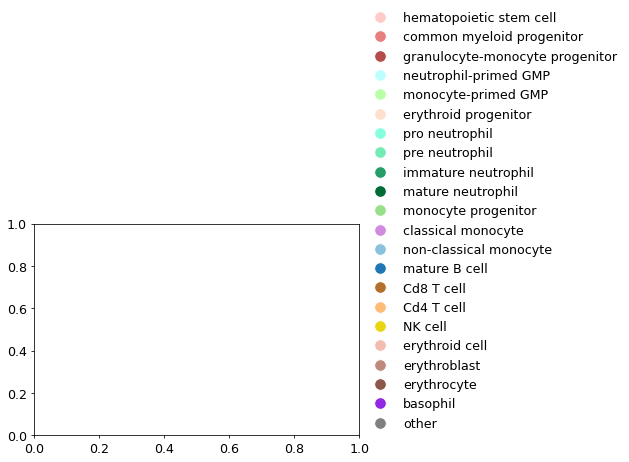

In [8]:
fig_width = 7
fig_height = 3

cond_to_label = {"Naive":"Naive", "Sham":"Sham", "MCAO":"MCAo"}
cond_to_color = {
    cond:color for cond, color in zip(adata.obs["condition"].cat.categories,adata.uns["condition_colors"])
}

celltypes = []

for cond in ["Naive", "Sham", "MCAO"]:
    df_, color_df = dfs_pseudo[cond], dfs_color[cond]
    
    # Adjust color_df to cell type that are present
    if ("other" in df_["celltype"]) and ("other" not in color_df["celltype"]):
        color_df = pd.concat([color_df, pd.DataFrame(index=[len(color_df)], data={"celltype":"other", "color":"#808080"})])
    color_df = color_df.loc[color_df["celltype"].isin(df_["celltype"].unique())]
    celltypes = np.unique(celltypes+color_df["celltype"].tolist()).tolist()
    
    # Upset plot
    ups = upsetplot.UpSet(
        df_, sort_by='input', sort_categories_by='input', show_counts=True, 
        intersection_plot_elements=0
    )#, facecolor=color)
    
    # Color bars by cell type
    ups.add_stacked_bars(
        by="celltype",
        colors={ct:color for ct, color in zip(color_df["celltype"], color_df["color"])}, 
        elements=5
    )    
    
    # Look up which combinations need to be marked as pseudo counts
    tmp = df_pseudo.loc[df_pseudo[f"{cond}_pseudo"]].reset_index()
    for _, row in tmp.iterrows():
        ups.style_subsets(present=[b for b in bones if row[b]], absent=[b for b in bones if not row[b]],facecolor="red") #,label="special")      
    
    axs = ups.plot()
    axs["extra0"].get_legend().remove()
    axs["extra0"].set_ylabel(cond_to_label[cond])
    axs["extra0"].yaxis.label.set_color(cond_to_color[cond])
    
    plt.gcf().set_size_inches(fig_width, fig_height)
    plt.gcf().savefig(f"./figures/DE_upset_{ct_key}_LFmin_{LFc_min}_{cond}.png", bbox_inches = "tight", transparent=False)    
    plt.show()    
    

    
# Plot for baseline    
df_ = df.copy()
axs = upsetplot.UpSet(df_, sort_by='input', sort_categories_by='input', show_counts=True, facecolor="black").plot()
plt.gcf().set_size_inches(fig_width, fig_height)
axs['intersections'].set_ylabel(" ")
plt.gcf().savefig(f"./figures/DE_upset_{ct_key}_LFmin_{LFc_min}_pooled.png", bbox_inches = "tight", transparent=True)
plt.show()
    
# Plot just for y axis label :'-(
df_ = df.copy()
axs = upsetplot.UpSet(df_, sort_by='input', sort_categories_by='input', show_counts=True, facecolor="black").plot()
plt.gcf().set_size_inches(fig_width, 9)
axs['intersections'].set_ylabel("# upregulated genes in group of bones")
plt.gcf().savefig(f"./figures/DE_upset_{ct_key}_LFmin_{LFc_min}_y_axis_label.png", bbox_inches = "tight", transparent=True)
plt.show()


# Plot legend

plt.figure()
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
cts_ref = adata.obs[ct_key].cat.categories.tolist() + ["other"]
colors_ref = adata.uns[f"{ct_key}_colors"].tolist() + ["#808080"]
order = [cts_ref.index(ct) for ct in celltypes]
colors = [colors_ref[idx] for idx in order]
dots = []
for _,row in pd.DataFrame(data = {"celltype":celltypes, "color":colors, "order":order}).sort_values("order").iterrows():
    dots.append(Line2D([0], [0], marker='o', color='w', label=row["celltype"],markerfacecolor=row["color"], markersize=12))
plt.legend(handles=dots, loc=[1.01,0.0], frameon=False)
plt.gcf().savefig(f"./figures/DE_upset_{ct_key}_LFmin_{LFc_min}_legend.png", bbox_inches = "tight", transparent=True)
plt.show()


# Tables with gene lists of upset groups

In [5]:
def write_DE_tables(adata, ct_key="level1", cond="Naive", LFc_min=1, n_cts=8):
    """
    """
    
    n_combs = 15
    
    df, _ = upset_dfs(adata,ct_key=ct_key,condition = cond,pval_max=0.05,LFchange_min=LFc_min,n_cts=n_cts)
    df = df[bones.tolist() + ["celltype"]].reset_index().set_index(bones.tolist())
    
    columns = []
    for idx in df.index.value_counts().index:
        df_ = df.loc[idx]
        columns.append(list(idx) + df_["index"].tolist())
        columns.append(list(idx) + df_["celltype"].tolist())
        
    pad_len = max([len(col) for col in columns])
    for col in columns:
        col += [''] * (pad_len - len(col))
        
    df_ = pd.DataFrame(
        columns = bones.tolist() + [''] * (pad_len - len(bones)) ,
        index = [col for i in range(len(df.index.unique())) for col in [f"comb{i} gene", f"comb{i} celltype"]],
        data = columns,
    ).T
    
    columns = {}
    for col in df_.iloc[:,::2].columns:
        columns[col] = df_.iloc[:5][col].tolist() + df_.iloc[5:][col].unique().tolist()
        
    pad_len = max([len(col) for col in columns.values()])
    for key in columns:
        columns[key] += [''] * (pad_len - len(columns[key]))
        
    df_2 = pd.DataFrame(
        index = bones.tolist() + [''] * (pad_len - len(bones)) ,
        data = columns,
    )
    
    df_.to_excel(Path(RESULTS_DIR, "DE_tests", "230219_upset_genes", f"with_ct_info_{ct_key}_{cond}_LFc_min_{LFc_min}.xlsx"))
    df_2.to_excel(Path(RESULTS_DIR, "DE_tests", "230219_upset_genes", f"unique_genes_{ct_key}_{cond}_LFc_min_{LFc_min}.xlsx"))

In [10]:
for cond in ["Naive","Sham","MCAO"]:    
    write_DE_tables(adata, ct_key="level1", cond=cond, LFc_min=1, n_cts=8)
    write_DE_tables(adata, ct_key="level1", cond=cond, LFc_min=2, n_cts=8)
    write_DE_tables(adata, ct_key="level2", cond=cond, LFc_min=1, n_cts=16)
    write_DE_tables(adata, ct_key="level2", cond=cond, LFc_min=2, n_cts=16)

<ipython-input-9-ccc44a6090a9>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = df.loc[idx]
<ipython-input-9-ccc44a6090a9>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = df.loc[idx]
<ipython-input-9-ccc44a6090a9>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_ = df.loc[idx]


In [8]:
pd.read_excel(Path(RESULTS_DIR, "DE_tests", "230219_upset_genes", f"with_ct_info_level1_Naive_LFc_min_1.xlsx"),index_col=0)

,comb0 gene,comb0 celltype,comb1 gene,comb1 celltype,comb2 gene,comb2 celltype,comb3 gene,comb3 celltype,comb4 gene,comb4 celltype,...,comb6 gene,comb6 celltype,comb7 gene,comb7 celltype,comb8 gene,comb8 celltype,comb9 gene,comb9 celltype,comb10 gene,comb10 celltype
Calvaria,0,0,1,1,1,1,0,0,1,1,...,1,1,1,1,0,0,1,1,0,0
Vertebra,1,1,0,0,0,0,0,0,1,1,...,1,1,1,1,0,0,0,0,1,1
Humerus,1,1,0,0,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,0,0
Femur,1,1,0,0,1,1,1,1,0,0,...,0,0,1,1,1,1,1,1,0,0
Pelvis,1,1,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,Nudt16l1,erythroid precursor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,Dcbld2,erythroid precursor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,Pacsin1,erythroid precursor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,Mpnd,erythroid precursor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# GO terms for gene lists

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 150
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [ ]:
from gprofiler_plotting import gprofiler_enrich
import scipy.cluster.hierarchy as sch
from matplotlib import colors

def GO_plot(genes,plot_heatmap=True,save_en=False,save_hm=False,show_plots=False,return_dfs=False,max_n_genes=150,save_gp_df=False):
    """
    """
    rcParams['figure.figsize']= (4.8,4.8)
    enrich_df = gprofiler_enrich(genes,
                                 save=save_en,
                                 plot=show_plots)
    if save_gp_df:
        enrich_df.sort_values('p_value').to_csv(save_gp_df)
    
    rcParams['figure.figsize']= (4.5+min(max_n_genes,len(genes)),6.5)
    if plot_heatmap:
        enrich_df = enrich_df.sort_values('p_value')[:20]
        hm_df = plot_GO_heatmap(genes,enrich_df,show=show_plots,save=save_hm,max_n_genes=max_n_genes)
    
        if return_dfs:
            return enrich_df, hm_df
    if return_dfs:
        return enrich_df 
    
def plot_GO_heatmap(genes,df,show=False,save=False,reorder_heatmap=True,max_n_genes=150):
    """
    max_n_genes: only show the top max_n_genes sorted based on number of GO terms
    """
    df_tmp = pd.DataFrame(index=df["name"],
                 columns=genes,
                 data={g:df["intersections"].apply(lambda gs: g in gs).astype(int).tolist() for g in genes}
                )
    if (len(df_tmp.columns) > 1) and max_n_genes:
        cols = df_tmp.sum().sort_values(ascending=False)[:min(len(df_tmp.columns),max_n_genes)].index.tolist()
        df_tmp = df_tmp[cols]
    
    if reorder_heatmap and (len(df_tmp.columns) > 1):
        # Reorder by linkage clustering
        pairwise_distances = sch.distance.pdist(df_tmp.values.T)
        linkage = sch.linkage(pairwise_distances, method="complete")
        cluster_distance_threshold = pairwise_distances.max() / 2
        idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, criterion="distance")
        idx = np.argsort(idx_to_cluster_array)
        df_tmp = df_tmp[df_tmp.columns[idx]]
        # Invert gene order if genes with fewer terms are on the left side of the heatmap
        mean_1st_half = df_tmp[df_tmp.columns[:len(df_tmp.columns)//2]].values.mean()
        mean_2nd_half = df_tmp[df_tmp.columns[len(df_tmp.columns)//2:]].values.mean()
        if mean_1st_half < mean_2nd_half:
            df_tmp = df_tmp[df_tmp.columns[::-1]]
    cmap = plt.get_cmap('Greens')
    new_cmap = truncate_colormap(cmap, 0.15, 0.8)
    hm = sns.heatmap(df_tmp,cmap=new_cmap, square=True, linewidths=.1, xticklabels=1, yticklabels=1, cbar=False)
    if save:
        fig = hm.get_figure()
        fig.savefig(save,bbox_inches = "tight")
    if show:
        plt.show()
    else:
        plt.close()
    return df_tmp 

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [23]:
def GO_plots_for_upset_gene_lists(cond="Naive",ct_key="level1",LFc_min=1,min_genes=4,show=True,save=False,save_gp_df=False):
    """
    """
    df = pd.read_excel(
        Path(RESULTS_DIR, "DE_tests", "230219_upset_genes", f"with_ct_info_{ct_key}_{cond}_LFc_min_{LFc_min}.xlsx"),
        index_col=0
    )
    
    bones = df.index[:5].tolist()
    
    for col in df.columns[::2]:
        
        up_in = "_".join([b for i,b in enumerate(bones) if bool(df[col].iloc[i])]) 
        
        comb = col.split(" ")[0]
        
        df_not_nan = ~df[col].isnull()
        celltypes = df.loc[df_not_nan,f"{comb} celltype"].iloc[5:]
        gene_list = np.unique(df.loc[df_not_nan,col].iloc[5:]).tolist()
        
        if len(gene_list) < min_genes:
            continue
        
        gene_list_per_ct = {}
        for ct in np.unique(celltypes):
            gene_list_temp = df.loc[df_not_nan & (df[f"{comb} celltype"] == ct), col].tolist()
            if len(gene_list_temp) >= min_genes:
                gene_list_per_ct[ct] = gene_list_temp
        
        fig_dir = Path(".","figures","DE_upset_GO",cond,f"{ct_key}_LFc_min_{LFc_min}",f"{comb}_up_in_{up_in}")
        if save:
            fig_dir.mkdir(parents=True, exist_ok=True)
        
        if save_gp_df:
            base_dir = Path(RESULTS_DIR,"DE_tests","230219_upset_genes","GO_tables",f"{cond}_{ct_key}_LFc_min_{LFc_min}")
            base_dir.mkdir(parents=True, exist_ok=True)
            save_df = Path(base_dir,f"{col.replace(' ','_')}.csv")
        else:
            save_df = False        
        
        GO_plot(
            gene_list,plot_heatmap=True,    
            save_en=Path(fig_dir, f"unique_genes_enrichment.png") if save else False,
            save_hm=Path(fig_dir, f"unique_genes_GO_gene_matrix.png") if save else False,
            show_plots=show,return_dfs=False,max_n_genes=200,save_gp_df=save_df
        )
        
        fig_dir = Path(".","figures","DE_upset_GO",cond,f"{ct_key}_LFc_min_{LFc_min}",f"{comb}_up_in_{up_in}", "gene_lists_per_celltype")
        if save:
            fig_dir.mkdir(parents=True, exist_ok=True)
        
        for i, (ct, g_list) in enumerate(gene_list_per_ct.items()):
            if show:
                print(f"########## {col} - {ct}")

            #if save_gp_df:
            #    base_dir = Path(RESULTS_DIR,"DE_tests","230219_upset_genes","GO_tables")
            #    base_dir.mkdir(parents=True, exist_ok=True)
            #    save_df = Path(base_dir,f"{cond}_{ct_key}_LFc_min_{LFc_min}_{ct.replace(' ','_')}.csv")
            #else:
            #    save_df = False
            
            GO_plot(
                g_list,plot_heatmap=True,
                save_en=Path(fig_dir, f"{i}_genes_of_{ct}_enrichment.png") if save else False,
                save_hm=Path(fig_dir, f"{i}_genes_of_{ct}_GO_gene_matrix.png") if save else False,
                show_plots=show,return_dfs=False,max_n_genes=200,save_gp_df=False
            )

##### Example run (with plots shown)

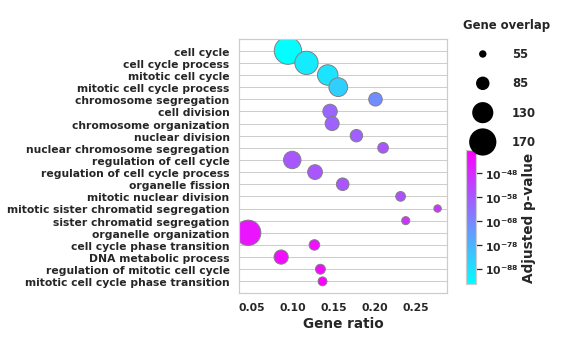

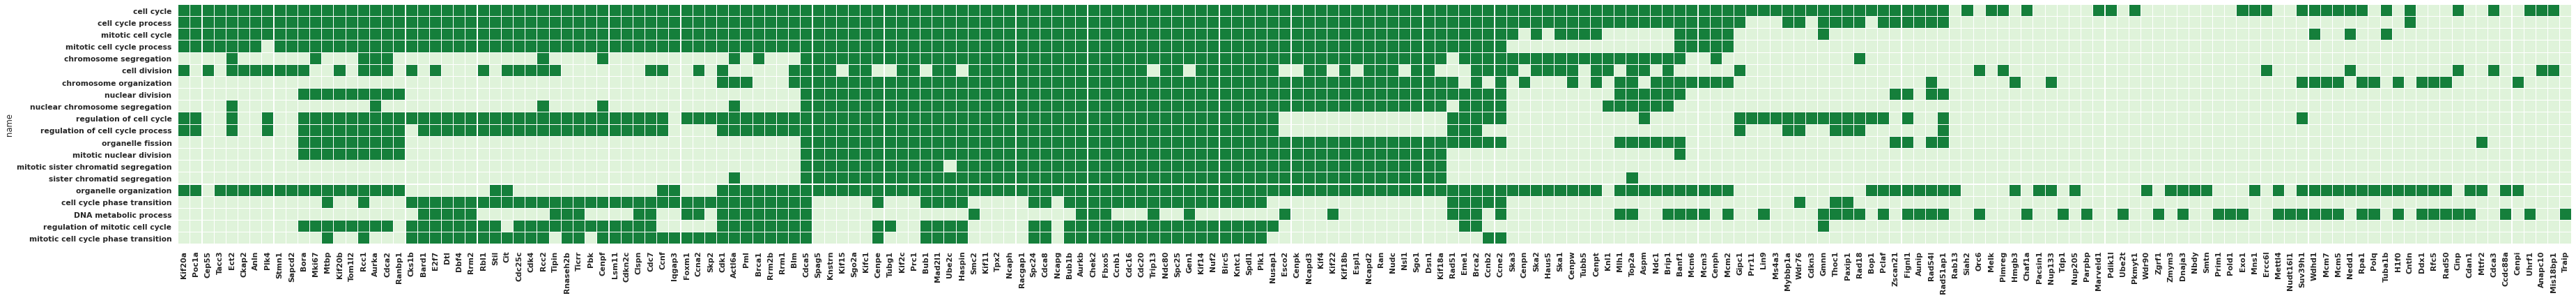

########## comb0 gene - erythroid precursor


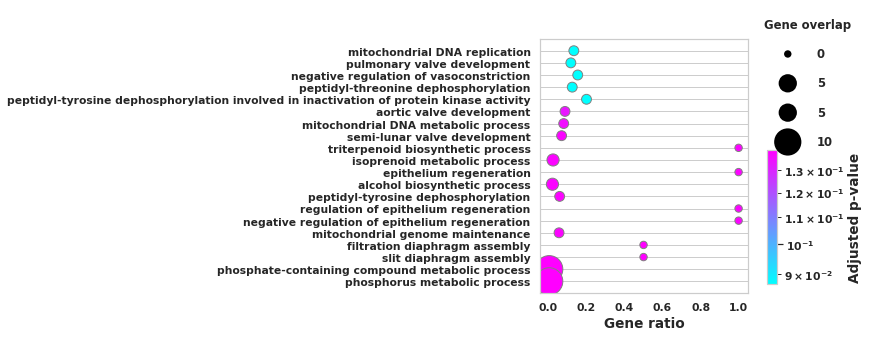

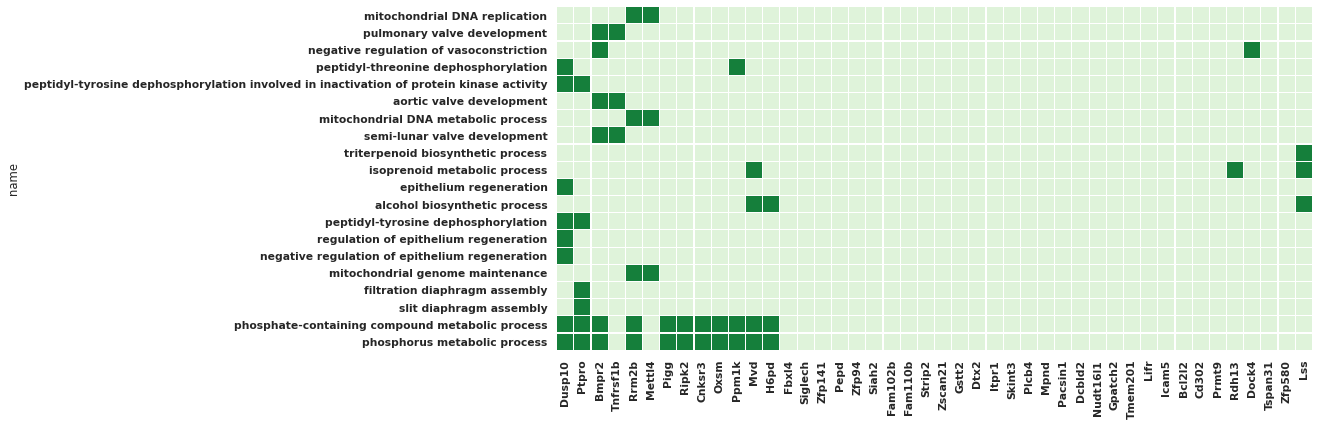

########## comb0 gene - neutrophil


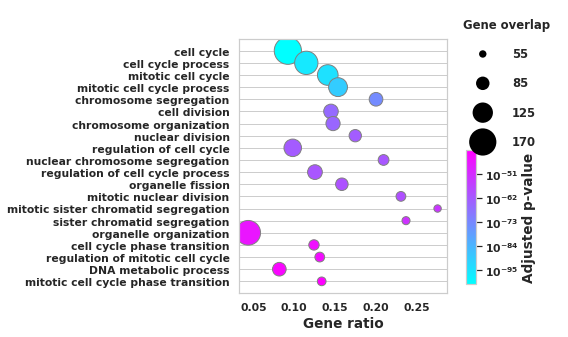

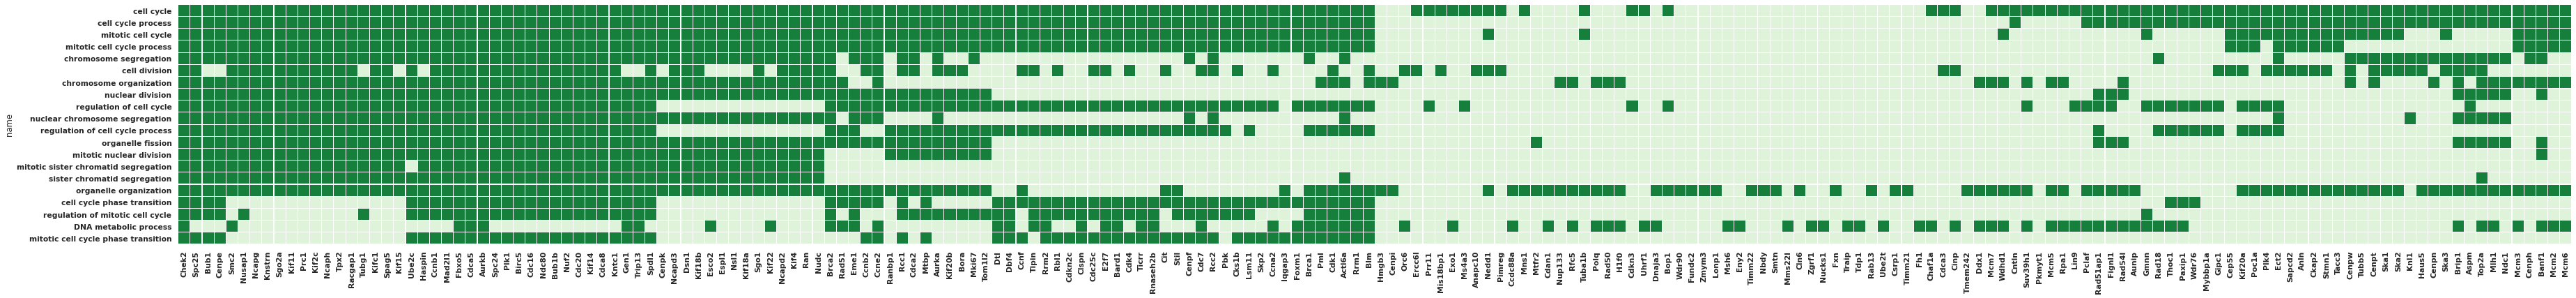

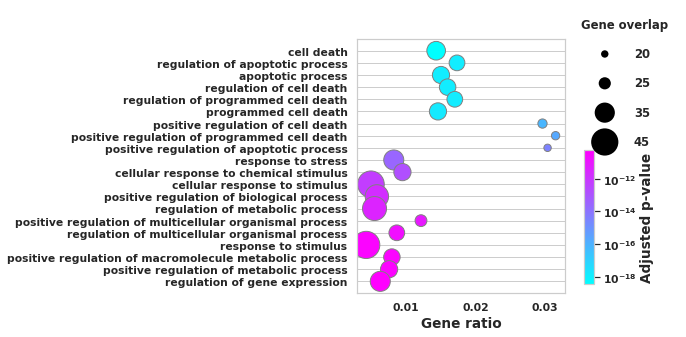

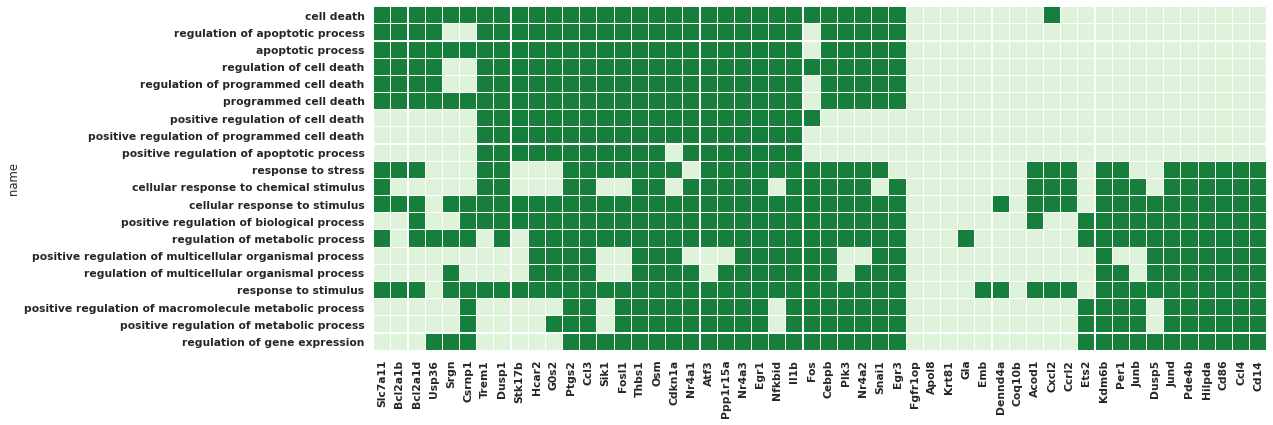

########## comb1 gene - B cell


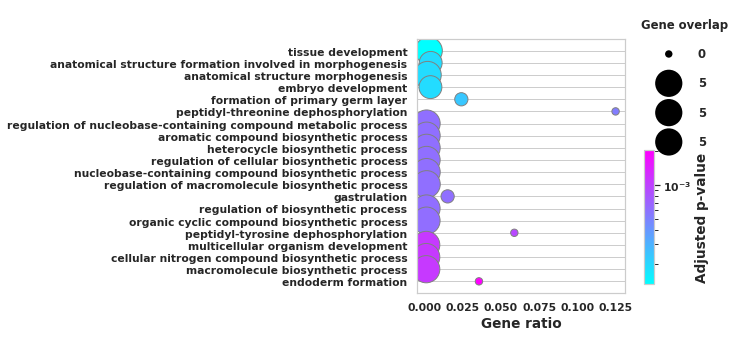

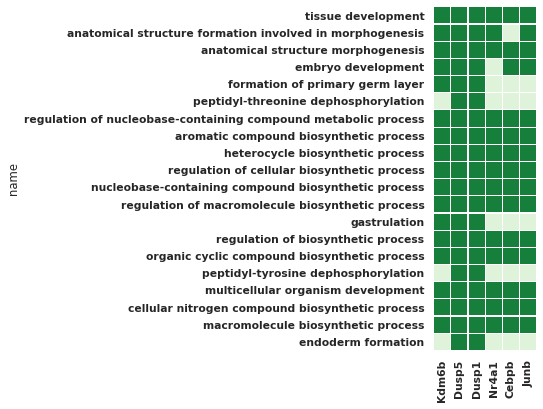

########## comb1 gene - monocyte


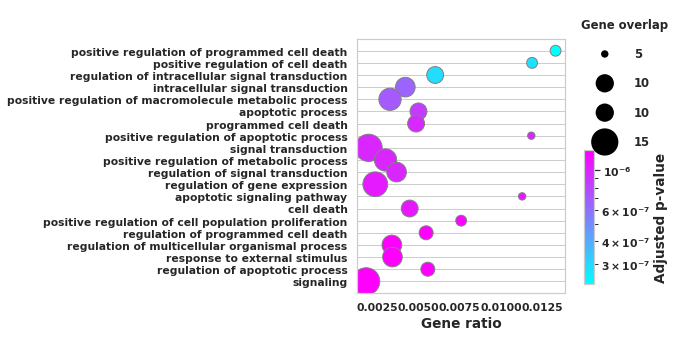

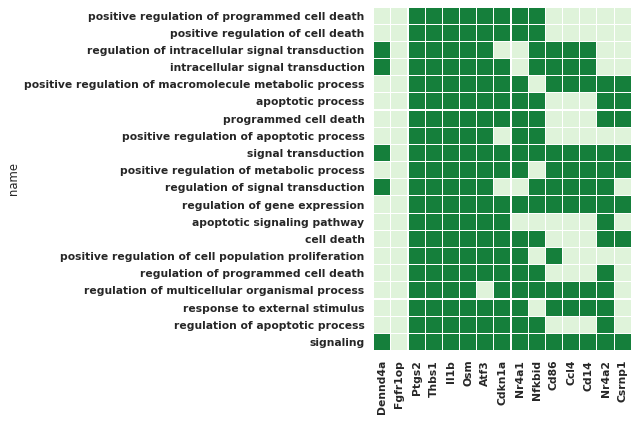

########## comb1 gene - neutrophil


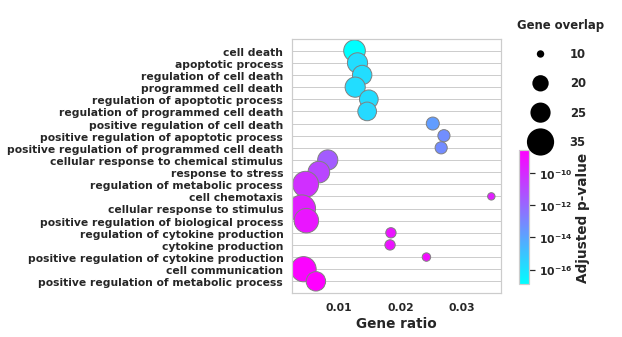

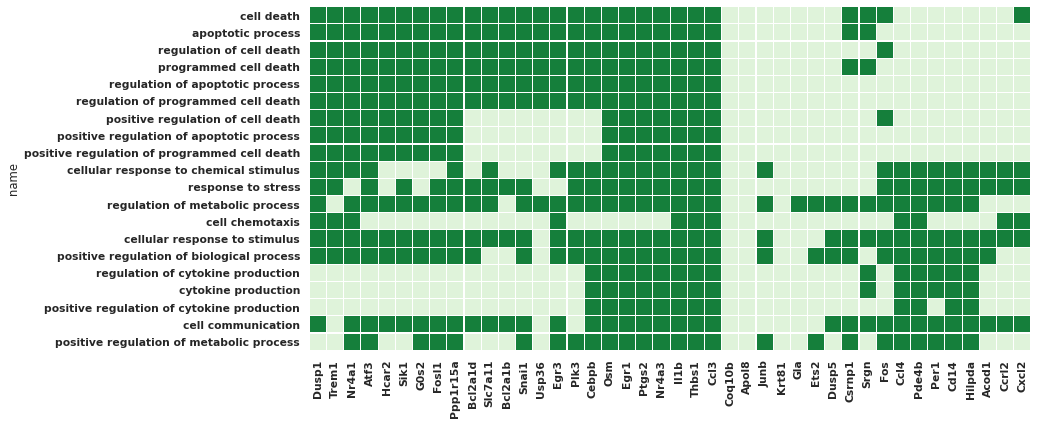

########## comb1 gene - progenitors


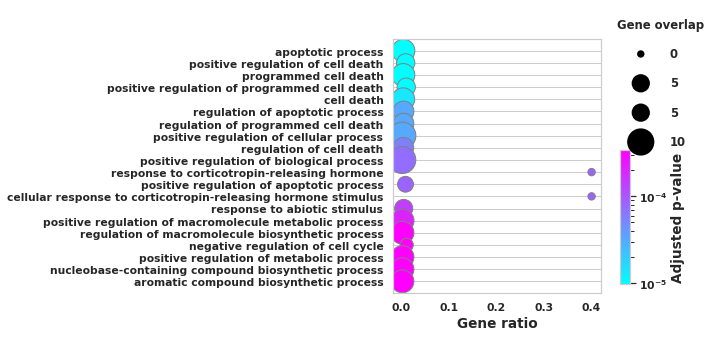

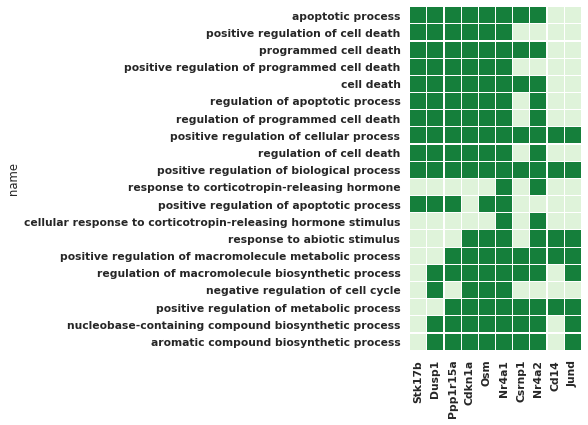

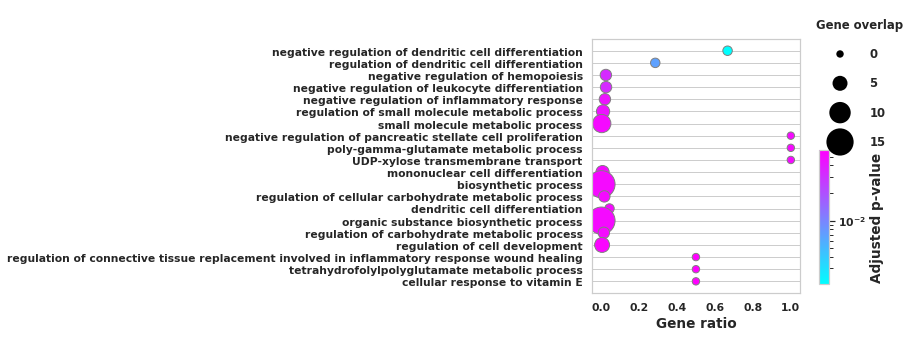

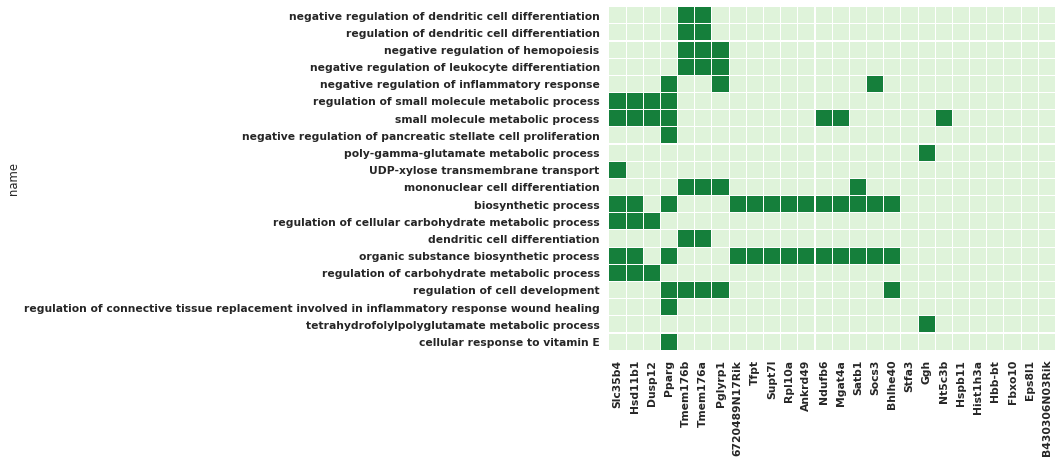

########## comb2 gene - B cell


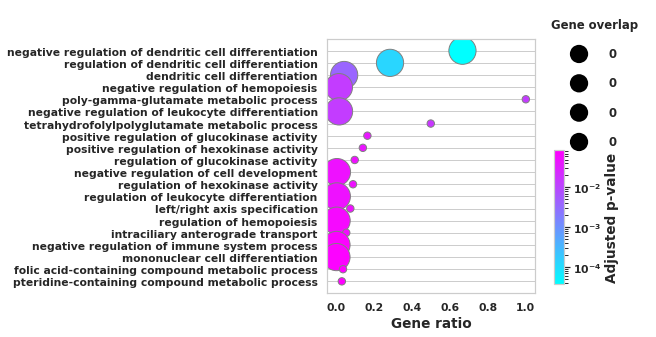

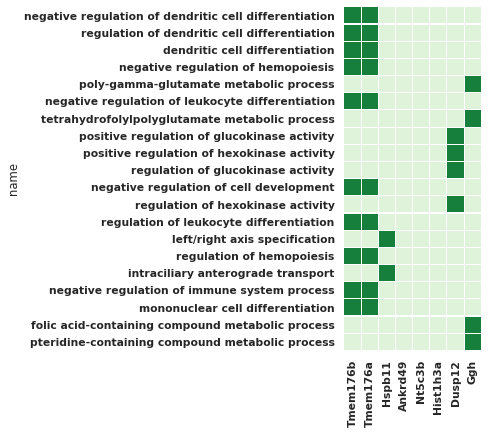

########## comb2 gene - erythroid precursor


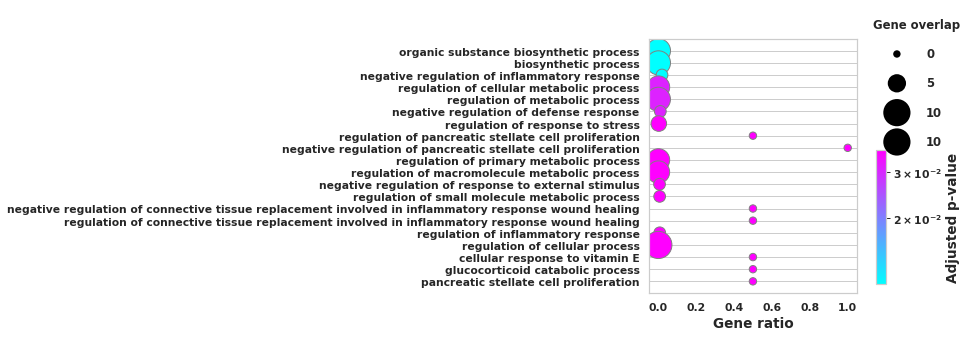

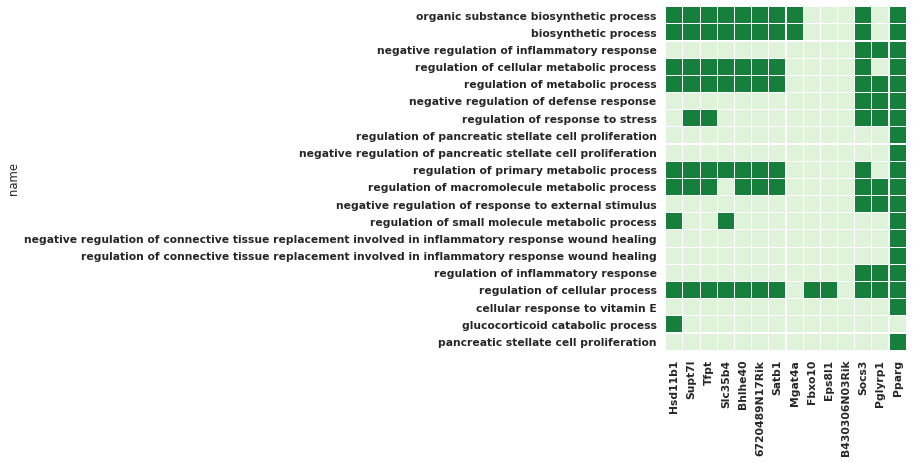

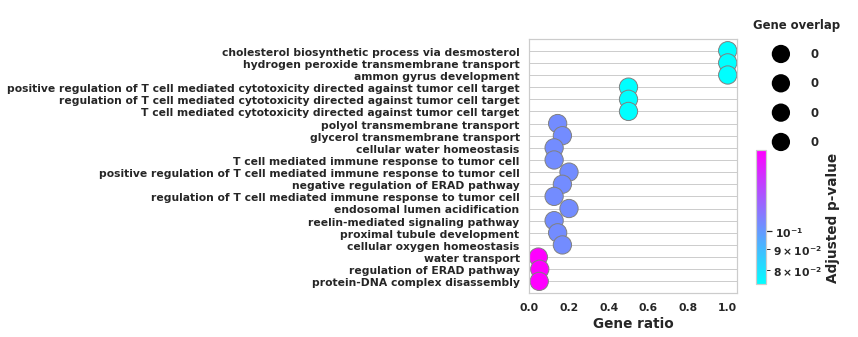

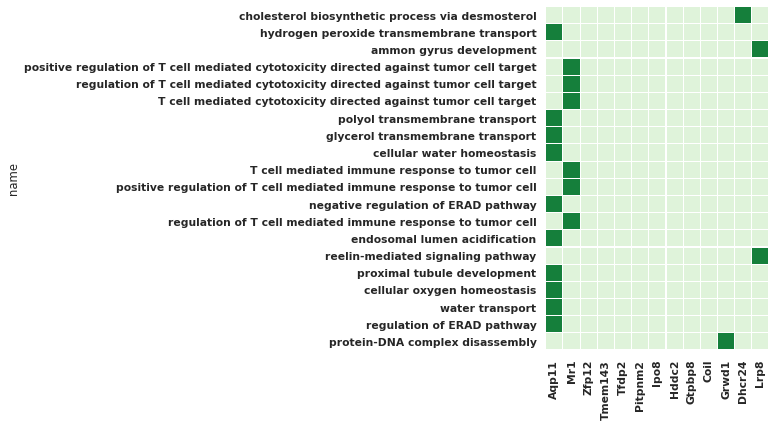

########## comb3 gene - erythroid precursor


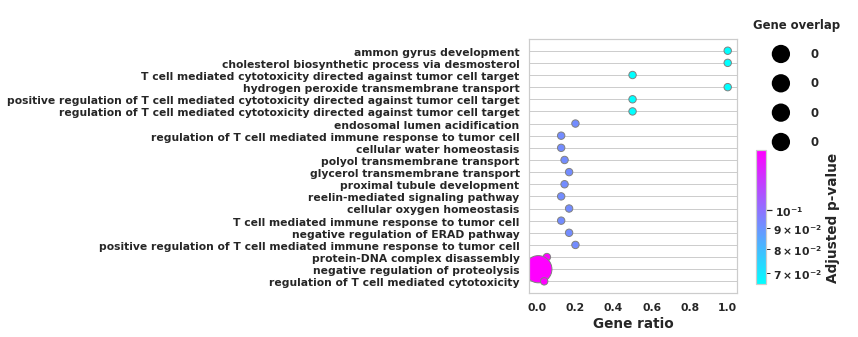

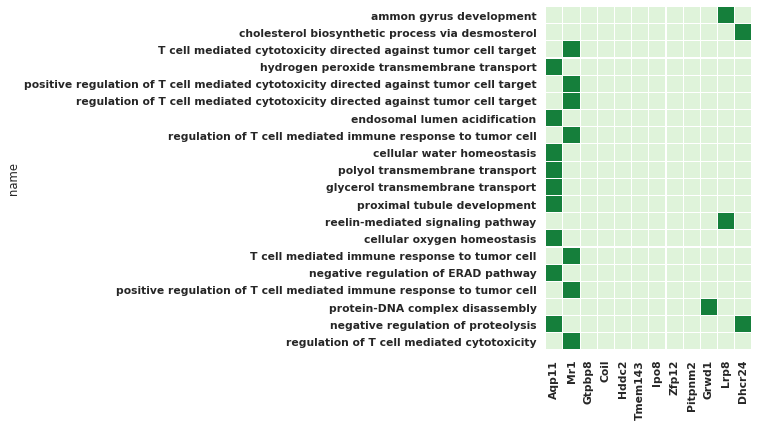

In [24]:
GO_plots_for_upset_gene_lists(
    cond="Naive",ct_key="level1",LFc_min=1,min_genes=4,show=True,save=True,save_gp_df=True
)

##### All runs (plots only saved in `./figures/DE_upset_GO/`, not shown)

gprofiler tables saved in `Path(RESULTS_DIR,"DE_tests","230219_upset_genes","GO_tables")`


In [25]:
MIN_GENES = 4

for cond in ["Naive","Sham","MCAO"]:
    for ct_key in ["level1", "level2"]:
        for LFc_min in [1,2]:
            print(f"### cond - {cond} | ct_key - {ct_key} | LFc_min - {LFc_min} ###")
            GO_plots_for_upset_gene_lists(
                cond=cond,ct_key=ct_key,LFc_min=LFc_min,min_genes=MIN_GENES,show=False,save=True,save_gp_df=True
            )

### cond - Naive | ct_key - level1 | LFc_min - 1 ###
### cond - Naive | ct_key - level1 | LFc_min - 2 ###
### cond - Naive | ct_key - level2 | LFc_min - 1 ###
### cond - Naive | ct_key - level2 | LFc_min - 2 ###
### cond - Sham | ct_key - level1 | LFc_min - 1 ###
### cond - Sham | ct_key - level1 | LFc_min - 2 ###
### cond - Sham | ct_key - level2 | LFc_min - 1 ###
### cond - Sham | ct_key - level2 | LFc_min - 2 ###
### cond - MCAO | ct_key - level1 | LFc_min - 1 ###
### cond - MCAO | ct_key - level1 | LFc_min - 2 ###
### cond - MCAO | ct_key - level2 | LFc_min - 1 ###
### cond - MCAO | ct_key - level2 | LFc_min - 2 ###


### Save multiple grpofiler tables as one excel sheet

We only take the combinations of Calvaria up and down (--> for each condition --> 6 excel sheets)

In [43]:
bones = ['Calvaria', 'Vertebra', 'Humerus', 'Femur', 'Pelvis']
combs_oi = {
    "Calvaria_up" : [1,0,0,0,0],
    "Calvaria_down" : [0,1,1,1,1],
}

for ct_key in ["level2"]: #["level1","level2"]:
    for LFc_min in [1]: #[1,2]:
        
        dfs = {}
        
        for cond in ["Naive","Sham","MCAO"]:        
            
            # Get gene list table to retrieve comb name info
            tmp = pd.read_excel(
                Path(
                    RESULTS_DIR, "DE_tests", "230219_upset_genes", 
                    f"unique_genes_{ct_key}_{cond}_LFc_min_{LFc_min}.xlsx"
            ),index_col=0)
            
            # Load gprofiler tables for each combination of interest
            for comb_name, comb in combs_oi.items():
                col = (tmp.loc[bones].T == comb).all(axis=1).idxmax()
                
                csv_file = Path(
                    RESULTS_DIR,"DE_tests","230219_upset_genes","GO_tables",
                    f"{cond}_{ct_key}_LFc_min_{LFc_min}",
                    f"{col.replace(' ','_')}.csv"
                )
                
                dfs[f"{cond} {comb_name}"] = pd.read_csv(csv_file,index_col=0)
            
        # Write to excel
        excel_file = Path(
            #RESULTS_DIR, "DE_tests","230219_upset_genes","GO_tables_excel",
            ".",
            f"DE_upset_GO_terms_{ct_key}_LFc_min_{LFc_min}.xlsx"
        )
        
        with pd.ExcelWriter(excel_file) as writer:
            for sheet,df in dfs.items():
                df.to_excel(writer, sheet_name=sheet)